In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 셋 불러오기

train = pd.read_csv("../../../data/dacon_parking_demand_dataset/train.csv")
test = pd.read_csv("../../../data/dacon_parking_demand_dataset/test.csv")
sub = pd.read_csv("../../../data/dacon_parking_demand_dataset/sample_submission.csv")
age = pd.read_csv("../../../data/dacon_parking_demand_dataset/age_gender_info.csv")

In [3]:
train.shape, test.shape

((2952, 15), (1022, 14))

In [4]:
# 오류1번 트레인 셋 처리
# 총세대수와 전용면적별 세대수 합이 다른 단지코드의 값을 -> 전용면적별세대수의 합으로 수정하기

def house_number_correction(df):
    error_1_group = df.groupby("단지코드")[["총세대수"]]
    total_number_house_hold = error_1_group.mean()

    error_2_group = df.groupby("단지코드")["전용면적별세대수"]
    sum_house_hold = error_2_group.sum()

    check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
    different_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

    total_house_index = different_df.index
    total_house_number = []
    for v in different_df.values:
        total_house_number.append(v[1])
    
    for code, value in zip(total_house_index, total_house_number):
         df.loc[df["단지코드"] == code, "총세대수"] = value
    
    return df

train = house_number_correction(train)
test = house_number_correction(test)

In [5]:
error_1_group = train.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = train.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

print(check_df.shape)
check_df

(0, 2)


,총세대수,전용면적별세대수
단지코드,,


In [6]:
error_1_group = test.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = test.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

check_df.shape

(0, 2)

In [7]:
# 오류2번 3번 처리하기

train[(train["단지코드"] == "C2675") | (train["단지코드"] == "C2335") | (train["단지코드"] == "C1327")]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [8]:
test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
579,C2675,512,아파트,경기도,국민임대,36.65,130,9.0,A,18476000,154790,0.0,3.0,1016.0
580,C2675,512,아파트,경기도,국민임대,46.90,44,9.0,A,34082000,232200,0.0,3.0,1016.0
581,C2675,512,아파트,경기도,국민임대,46.90,80,9.0,A,34082000,232200,0.0,3.0,1016.0


In [9]:
# 테스트 데이터 셋에서 세개의 코드 데이터를 없애기 (2, 3번 3개 코드 제거)

error_index = test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].index
test = test.drop(index=error_index, axis=0)

In [10]:
# 에러2번의 5개 단지코드 트레인 셋 제거

train_set_error_index = train[(train["단지코드"] =="C2085") | (train["단지코드"] =="C1397") | (train["단지코드"] =="C2431") | (train["단지코드"] =="C1649") | (train["단지코드"] =="C1036")].index
train = train.drop(index=train_set_error_index, axis=0)

In [11]:
# 에러3번의 트레인 셋 7개 단지 코드 제거

train_set_error_index = train[(train["단지코드"] =="C1095") | (train["단지코드"] =="C2051") | (train["단지코드"] =="C1218") | (train["단지코드"] =="C1894") | (train["단지코드"] =="C2483") | (train["단지코드"] =="C1502") | (train["단지코드"] =="C1988")].index
train = train.drop(index=train_set_error_index, axis=0)

In [12]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [13]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [14]:
# 임대보증금 피처 전처리
# 임대보증금이 0 혹은 "-" 인 데이터를 0으로 처리

train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)

### 임대보증금 결측치를 지역별 평균 임대보증금 값으로 처리

In [15]:
grouped = train_df.groupby( '지역')['임대보증금']
a=grouped.mean()
a.index

Index(['강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시',
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도'],
      dtype='object', name='지역')

In [16]:
tra=[]
for i in a.index:
    tra.append(i)
tra

['강원도',
 '경기도',
 '경상남도',
 '경상북도',
 '광주광역시',
 '대구광역시',
 '대전광역시',
 '부산광역시',
 '서울특별시',
 '세종특별자치시',
 '울산광역시',
 '전라남도',
 '전라북도',
 '제주특별자치도',
 '충청남도',
 '충청북도']

In [17]:
grouped = train_df.groupby([ '지역'])
for val in tra:
    group1 = grouped.get_group( ( val )  )
    imde = train_df[(train_df["임대보증금"] == 0) & (train_df["지역"] == val)].index
    train_df.loc[imde, "임대보증금"] = group1['임대보증금'].mean()
    
    imde_test = test_df[(test_df["임대보증금"] == 0) & (test_df["지역"] == val)].index
    test_df.loc[imde_test, "임대보증금"] = group1["임대보증금"].mean()

In [18]:
train_df["임대보증금"].isnull().sum()

0

In [19]:
test_df["임대보증금"].isnull().sum()

0

<AxesSubplot:>

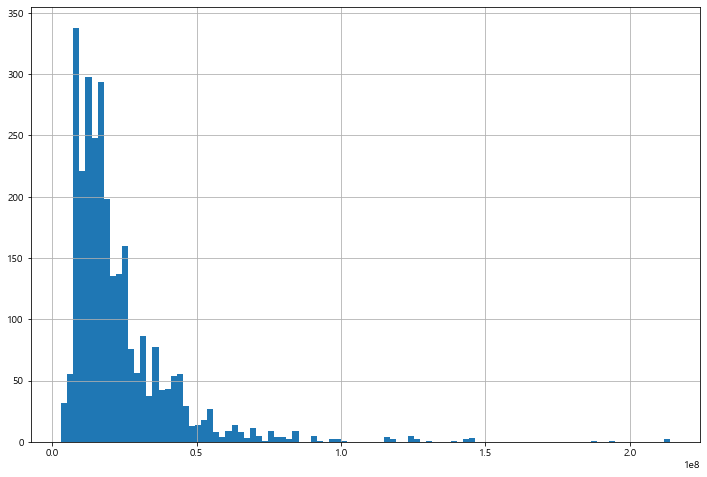

In [20]:
train_df["임대보증금"].hist(bins=100, figsize=(12, 8))

In [21]:
train_df["임대보증금"].value_counts()

7.469610e+06    225
1.293120e+07    120
1.573167e+07     97
9.905058e+06     76
1.463549e+07     35
               ... 
1.599200e+07      1
2.836900e+07      1
2.179200e+07      1
2.017300e+07      1
2.483700e+07      1
Name: 임대보증금, Length: 932, dtype: int64

In [22]:
train_df["임대보증금"].skew()

3.4263400855772983

In [23]:
train_df["임대보증금"].kurt()

20.089738044778837

In [24]:
# 레이블 인코딩인데, 원핫 인코딩으로 바꿔보기

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [25]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [26]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

In [27]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [28]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [29]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

In [32]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [33]:
train_df[train_df["단지코드"] == "C1039"]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,대구광역시,대전광역시,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000.0,...,0,0,0,0,0,0,0,0,0,0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2103,C1039,790,아파트,서울특별시,국민임대,26.68,26,13.0,A,15282000.0,...,0,0,0,0,0,0,0,0,0,0
2104,C1039,790,아파트,서울특별시,국민임대,36.70,140,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2105,C1039,790,아파트,서울특별시,국민임대,36.70,14,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2106,C1039,790,아파트,서울특별시,국민임대,36.87,43,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2107,C1039,790,아파트,서울특별시,국민임대,46.76,192,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2108,C1039,790,아파트,서울특별시,국민임대,46.96,25,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2109,C1039,790,아파트,서울특별시,영구임대,26.68,70,13.0,I,11490000.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [35]:
# 전용 면적 피처를 5의 배수로 전처리

train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [36]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [37]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [38]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [39]:
train_df["공급유형"].value_counts()

국민임대         1727
임대상가          562
행복주택          202
공공임대(10년)     175
영구임대          152
공공임대(50년)      31
공공분양            7
공공임대(분납)        7
장기전세            3
공공임대(5년)        3
Name: 공급유형, dtype: int64

In [40]:
train_df[train_df["공급유형"] == "장기전세"]

,단지코드,총세대수,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,...,전라남도,전라북도,제주특별자치도,충청남도,충청북도,상가,아파트,세대수 규모 당 총 전용면적,단지별 총 전용면적,전용면적 당 차량등록수
2100,C1039,790,서울특별시,장기전세,50.0,126,13.0,A,187694000.0,-,...,0,0,0,0,0,0,1,6300.0,33080.0,122.838573
2101,C1039,790,서울특별시,장기전세,55.0,49,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,2695.0,33080.0,52.547612
2102,C1039,790,서울특별시,장기전세,55.0,75,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,4125.0,33080.0,80.430018


In [41]:
test_df["공급유형"].value_counts() # 테스트 셋에는 없는 공급유형 -> 공공분양, 공공임대(5년), 장기전세

국민임대         614
임대상가         177
행복주택         120
영구임대          43
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64

In [42]:
supply_qualification_df = pd.get_dummies(train_df["공급유형"])
train_df = pd.concat([train_df, supply_qualification_df], axis=1)

supply_qualification_df = pd.get_dummies(test_df["공급유형"])
test_df = pd.concat([test_df, supply_qualification_df], axis=1)
test_df["공공임대(5년)"] = 0
test_df["공공분양"] = 0
test_df["장기전세"] = 0

In [43]:
train_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도',
       '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도',
       '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적',
       '단지별 총 전용면적', '전용면적 당 차량등록수', '공공분양', '공공임대(10년)', '공공임대(50년)',
       '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [44]:
test_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'B', 'F', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적',
       '공공임대(10년)', '공공임대(50년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '행복주택',
       '공공임대(5년)', '공공분양', '장기전세'],
      dtype='object')

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   지역                            2869 non-null   object 
 3   공급유형                          2869 non-null   object 
 4   전용면적                          2869 non-null   float64
 5   전용면적별세대수                      2869 non-null   int64  
 6   공가수                           2869 non-null   float64
 7   자격유형                          2869 non-null   object 
 8   임대보증금                         2869 non-null   float64
 9   임대료                           2300 non-null   object 
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 12  단지내주차면수                       2869 non-null   float64
 13  등록차

### 전처리한 피처들의 선형성 검증 이변량 분석

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

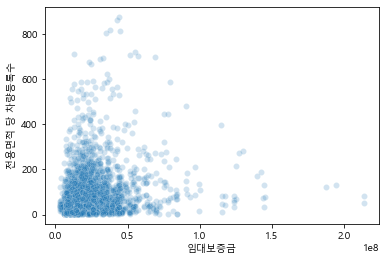

In [46]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='전용면적 당 차량등록수'>

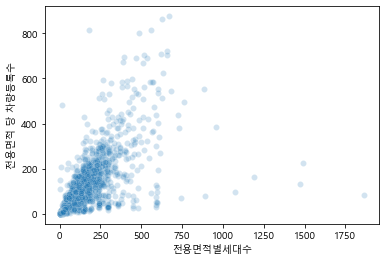

In [47]:
sns.scatterplot(data=train_df, x="전용면적별세대수", y="전용면적 당 차량등록수", alpha=0.2)

In [48]:
# 503, 1871, 1951, 1977, 2023

outlier_index = train_df[train_df["전용면적별세대수"] >= 1000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [49]:
outlier_index = train_df[(train_df["전용면적별세대수"] <= 30) & (train_df["전용면적 당 차량등록수"] >=400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [50]:
# 301 아웃라이어 제거

train_df[(train_df["전용면적별세대수"] > 150) & (train_df["전용면적 당 차량등록수"] > 750)]

train_df = train_df.drop(index=301, axis=0)

<AxesSubplot:xlabel='전용면적별세대수', ylabel='Count'>

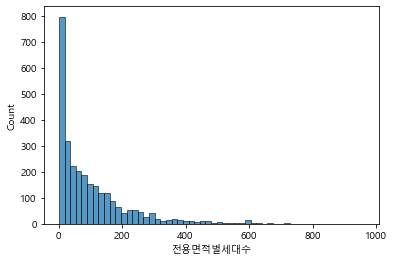

In [51]:
sns.histplot(train_df["전용면적별세대수"])

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='전용면적 당 차량등록수'>

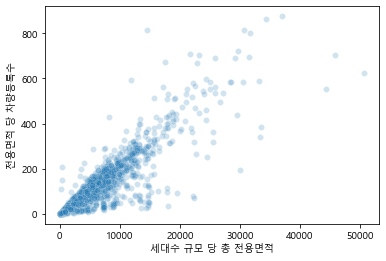

In [52]:
sns.scatterplot(data=train_df, x="세대수 규모 당 총 전용면적", y="전용면적 당 차량등록수", alpha=0.2)

In [53]:
# 1974, 2141, 2532

outlier_index = train_df[train_df["세대수 규모 당 총 전용면적"] > 40000].index

train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수 규모 당 총 전용면적', ylabel='Count'>

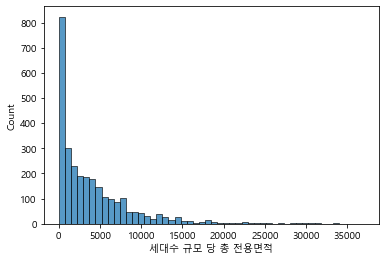

In [54]:
sns.histplot(train_df["세대수 규모 당 총 전용면적"])

<AxesSubplot:xlabel='임대보증금', ylabel='전용면적 당 차량등록수'>

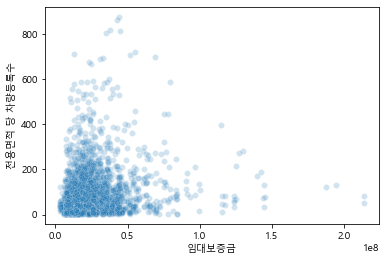

In [59]:
sns.scatterplot(data=train_df, x="임대보증금", y="전용면적 당 차량등록수", alpha=0.2)

In [60]:
# 임대보증금 아웃라이어 2111, 2812, 2813, 2814 제거

outlier_index = train_df[train_df["임대보증금"] >= 187694000].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:xlabel='세대수비율주차면수', ylabel='전용면적 당 차량등록수'>

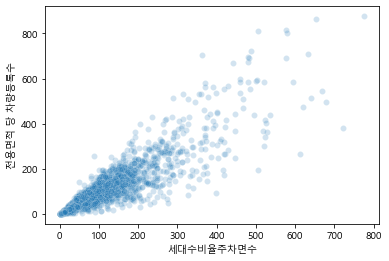

In [73]:
sns.scatterplot(data=train_df, x="세대수비율주차면수", y="전용면적 당 차량등록수", alpha=0.2)

In [74]:
# 세대수비율주차면수 아웃라이어 제거 314

outlier_index = train_df[(train_df["세대수비율주차면수"] >= 700) & (train_df["전용면적 당 차량등록수"] < 400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

<AxesSubplot:>

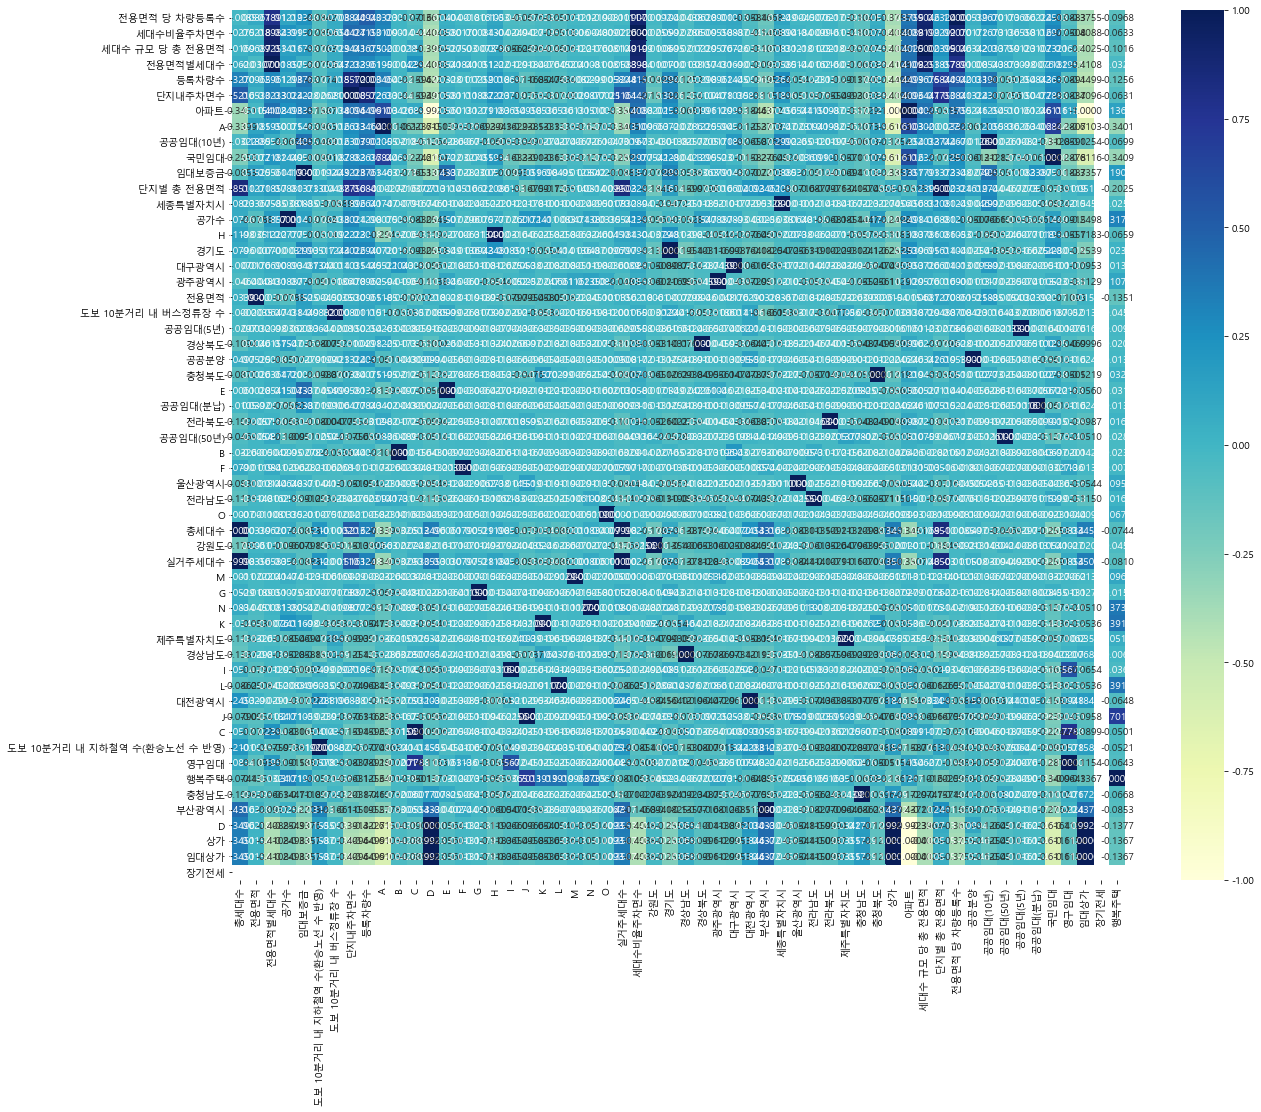

In [75]:
correlation_df = train_df.corr().sort_values(by="전용면적 당 차량등록수", ascending=False)

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_df, annot=True, fmt=".4f", cmap='YlGnBu')

In [76]:
# X_train & X_test 셋 선택

# ["상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
#  "전용면적 당 차량등록수", "총세대수"]

X_train_df_sel = train_df.drop(["단지코드", "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "전용면적 당 차량등록수", "총세대수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "상가", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "총세대수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [77]:
X_train_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [78]:
column_names = ['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [79]:
X_train_df_sel

,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,E,...,공공분양,공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,임대상가,장기전세,행복주택
8,276,17.0,9216000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,60,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,20,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11,38,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12,19,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,19,7.0,11346000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2948,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2949,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2950,114,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [80]:
X_train_df_log = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_log = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df_log = y_train_df.apply(lambda x: np.log1p(x))

### Linear Regression 모델 평가

In [81]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor

In [82]:
X_train_df_log.shape, X_test_df_log.shape, y_train_df_log.shape

((2854, 48), (1008, 48), (2854,))

In [83]:
params = {"alpha": [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
ridge_model = Ridge()

grid_model = GridSearchCV(ridge_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_model.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1,
                                   1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40,
                                   50]},
             scoring='neg_mean_absolute_error')

In [84]:
grid_model.best_params_

{'alpha': 40}

In [85]:
best_ridge = grid_model.best_estimator_
best_ridge

Ridge(alpha=40)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = best_ridge.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.962807838868052

In [87]:
ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train_df_log, y_train_df_log)
pred = ridge_model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})

sub_df

,code,num
0,C1072,694.475394
1,C1128,1178.397639
2,C1456,564.439391
3,C1840,488.414351
4,C1332,1120.588279
...,...,...
145,C2456,230.356296
146,C1266,422.865811
147,C2152,31.451186
148,C1267,316.394377


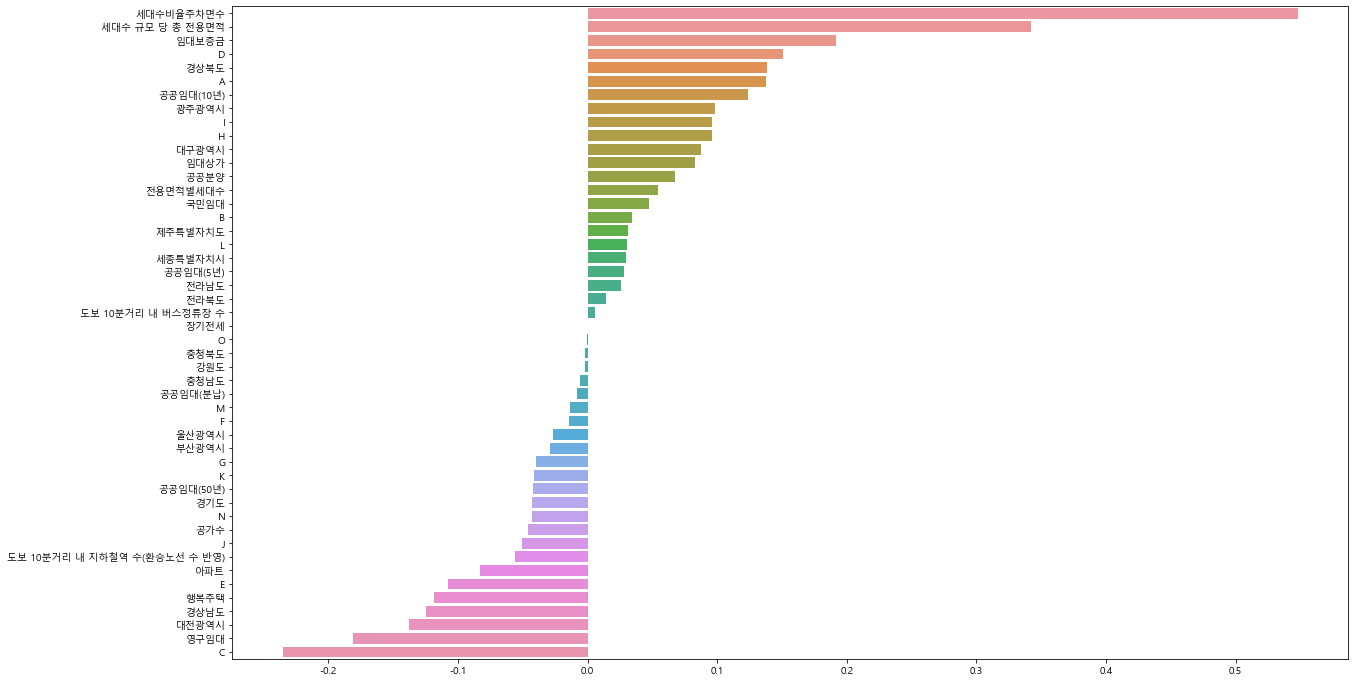

In [88]:
importance = ridge_model.coef_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [89]:
cat_reg = CatBoostRegressor()

cat_reg.fit(X_train, y_train)
pred = cat_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

Learning rate set to 0.04469
0:	learn: 1.7666903	total: 151ms	remaining: 2m 30s
1:	learn: 1.6950178	total: 156ms	remaining: 1m 17s
2:	learn: 1.6283976	total: 157ms	remaining: 52.3s
3:	learn: 1.5615487	total: 159ms	remaining: 39.5s
4:	learn: 1.5005376	total: 160ms	remaining: 31.8s
5:	learn: 1.4392658	total: 161ms	remaining: 26.7s
6:	learn: 1.3816450	total: 162ms	remaining: 23s
7:	learn: 1.3295048	total: 163ms	remaining: 20.3s
8:	learn: 1.2761381	total: 165ms	remaining: 18.1s
9:	learn: 1.2264596	total: 166ms	remaining: 16.4s
10:	learn: 1.1803827	total: 167ms	remaining: 15s
11:	learn: 1.1349174	total: 168ms	remaining: 13.9s
12:	learn: 1.0913901	total: 170ms	remaining: 12.9s
13:	learn: 1.0504940	total: 171ms	remaining: 12s
14:	learn: 1.0117175	total: 172ms	remaining: 11.3s
15:	learn: 0.9730420	total: 173ms	remaining: 10.6s
16:	learn: 0.9376305	total: 174ms	remaining: 10.1s
17:	learn: 0.9023564	total: 175ms	remaining: 9.56s
18:	learn: 0.8713782	total: 176ms	remaining: 9.11s
19:	learn: 0.839

162:	learn: 0.2186610	total: 349ms	remaining: 1.79s
163:	learn: 0.2183117	total: 351ms	remaining: 1.79s
164:	learn: 0.2178524	total: 352ms	remaining: 1.78s
165:	learn: 0.2174733	total: 353ms	remaining: 1.77s
166:	learn: 0.2172972	total: 354ms	remaining: 1.77s
167:	learn: 0.2169896	total: 356ms	remaining: 1.76s
168:	learn: 0.2166293	total: 357ms	remaining: 1.75s
169:	learn: 0.2162120	total: 358ms	remaining: 1.75s
170:	learn: 0.2156645	total: 359ms	remaining: 1.74s
171:	learn: 0.2152906	total: 361ms	remaining: 1.74s
172:	learn: 0.2149584	total: 362ms	remaining: 1.73s
173:	learn: 0.2146325	total: 363ms	remaining: 1.72s
174:	learn: 0.2142141	total: 364ms	remaining: 1.72s
175:	learn: 0.2137905	total: 366ms	remaining: 1.71s
176:	learn: 0.2133313	total: 367ms	remaining: 1.71s
177:	learn: 0.2130047	total: 368ms	remaining: 1.7s
178:	learn: 0.2127827	total: 369ms	remaining: 1.69s
179:	learn: 0.2125299	total: 371ms	remaining: 1.69s
180:	learn: 0.2122839	total: 372ms	remaining: 1.68s
181:	learn: 0

442:	learn: 0.1549090	total: 688ms	remaining: 865ms
443:	learn: 0.1547303	total: 689ms	remaining: 863ms
444:	learn: 0.1545510	total: 690ms	remaining: 861ms
445:	learn: 0.1543418	total: 692ms	remaining: 859ms
446:	learn: 0.1542250	total: 693ms	remaining: 857ms
447:	learn: 0.1540879	total: 694ms	remaining: 855ms
448:	learn: 0.1539404	total: 695ms	remaining: 853ms
449:	learn: 0.1537136	total: 697ms	remaining: 851ms
450:	learn: 0.1535583	total: 698ms	remaining: 849ms
451:	learn: 0.1534615	total: 699ms	remaining: 847ms
452:	learn: 0.1532725	total: 700ms	remaining: 845ms
453:	learn: 0.1531292	total: 701ms	remaining: 843ms
454:	learn: 0.1529470	total: 703ms	remaining: 842ms
455:	learn: 0.1527988	total: 704ms	remaining: 840ms
456:	learn: 0.1526410	total: 705ms	remaining: 838ms
457:	learn: 0.1526220	total: 706ms	remaining: 836ms
458:	learn: 0.1524696	total: 708ms	remaining: 834ms
459:	learn: 0.1524507	total: 709ms	remaining: 832ms
460:	learn: 0.1523171	total: 710ms	remaining: 830ms
461:	learn: 

723:	learn: 0.1212490	total: 1.02s	remaining: 391ms
724:	learn: 0.1211797	total: 1.03s	remaining: 390ms
725:	learn: 0.1210914	total: 1.03s	remaining: 388ms
726:	learn: 0.1209504	total: 1.03s	remaining: 387ms
727:	learn: 0.1208900	total: 1.03s	remaining: 385ms
728:	learn: 0.1207975	total: 1.03s	remaining: 384ms
729:	learn: 0.1206229	total: 1.03s	remaining: 382ms
730:	learn: 0.1205806	total: 1.03s	remaining: 381ms
731:	learn: 0.1204662	total: 1.03s	remaining: 379ms
732:	learn: 0.1202993	total: 1.04s	remaining: 378ms
733:	learn: 0.1202256	total: 1.04s	remaining: 376ms
734:	learn: 0.1201816	total: 1.04s	remaining: 375ms
735:	learn: 0.1200096	total: 1.04s	remaining: 373ms
736:	learn: 0.1199190	total: 1.04s	remaining: 372ms
737:	learn: 0.1198140	total: 1.04s	remaining: 370ms
738:	learn: 0.1197219	total: 1.04s	remaining: 369ms
739:	learn: 0.1196275	total: 1.04s	remaining: 367ms
740:	learn: 0.1194655	total: 1.05s	remaining: 366ms
741:	learn: 0.1193591	total: 1.05s	remaining: 364ms
742:	learn: 

999:	learn: 0.0986455	total: 1.36s	remaining: 0us


9.258290227385833

In [94]:
# 릿지 1.0                 -> 14.9751 Score: 95.6543 (인구데이터 X)
# 릿지 0.5 & LGBM 0.5 조합 -> 12.3456 Score: 93.5424 (인구데이터 추가)

# 릿지 0.9 & CatBoost 0.1 조합 -> 14.18295
# 릿지 0.8 & CatBoost 0.2 조합 -> 13.4380
# 릿지 0.7 & CatBoost 0.3 조합 -> 12.7728
# 릿지 0.6 & CatBoost 0.4 조합 -> 12.1470
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6074

# 릿지 alpha=50, 값으로 성능 평가
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6044
# 릿지 0.4 & CatBoost 0.6 조합 -> 11.0139
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.5106

# 릿지 alpha=40,값으로 성능 평가
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.4283
# 릿지 0.4 & CatBoost 0.6 조합 -> 10.9511

ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

final_pred = (ridge_pred * 0.3) + (cat_pred * 0.7)
mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

Learning rate set to 0.04469
0:	learn: 1.7651104	total: 1.61ms	remaining: 1.61s
1:	learn: 1.6931987	total: 3.06ms	remaining: 1.53s
2:	learn: 1.6262732	total: 4.52ms	remaining: 1.5s
3:	learn: 1.5623421	total: 5.88ms	remaining: 1.46s
4:	learn: 1.4990656	total: 7.29ms	remaining: 1.45s
5:	learn: 1.4378812	total: 8.68ms	remaining: 1.44s
6:	learn: 1.3806417	total: 10ms	remaining: 1.42s
7:	learn: 1.3250999	total: 11.3ms	remaining: 1.4s
8:	learn: 1.2737974	total: 12.6ms	remaining: 1.39s
9:	learn: 1.2243690	total: 14ms	remaining: 1.39s
10:	learn: 1.1781528	total: 15.5ms	remaining: 1.39s
11:	learn: 1.1351365	total: 16.7ms	remaining: 1.38s
12:	learn: 1.0912127	total: 18.2ms	remaining: 1.38s
13:	learn: 1.0498541	total: 19.6ms	remaining: 1.38s
14:	learn: 1.0092679	total: 20.9ms	remaining: 1.38s
15:	learn: 0.9704660	total: 22.5ms	remaining: 1.38s
16:	learn: 0.9337089	total: 23.7ms	remaining: 1.37s
17:	learn: 0.8990754	total: 25.2ms	remaining: 1.37s
18:	learn: 0.8664793	total: 26.4ms	remaining: 1.36s

265:	learn: 0.1893216	total: 332ms	remaining: 916ms
266:	learn: 0.1889560	total: 333ms	remaining: 915ms
267:	learn: 0.1885500	total: 335ms	remaining: 914ms
268:	learn: 0.1883084	total: 336ms	remaining: 913ms
269:	learn: 0.1880575	total: 337ms	remaining: 911ms
270:	learn: 0.1877316	total: 338ms	remaining: 910ms
271:	learn: 0.1876724	total: 340ms	remaining: 909ms
272:	learn: 0.1871145	total: 341ms	remaining: 908ms
273:	learn: 0.1868262	total: 342ms	remaining: 906ms
274:	learn: 0.1867517	total: 343ms	remaining: 905ms
275:	learn: 0.1866158	total: 345ms	remaining: 904ms
276:	learn: 0.1865437	total: 346ms	remaining: 902ms
277:	learn: 0.1861780	total: 347ms	remaining: 901ms
278:	learn: 0.1861076	total: 348ms	remaining: 900ms
279:	learn: 0.1858816	total: 349ms	remaining: 898ms
280:	learn: 0.1858130	total: 351ms	remaining: 897ms
281:	learn: 0.1856043	total: 352ms	remaining: 896ms
282:	learn: 0.1853657	total: 353ms	remaining: 894ms
283:	learn: 0.1853051	total: 354ms	remaining: 893ms
284:	learn: 

548:	learn: 0.1391061	total: 671ms	remaining: 551ms
549:	learn: 0.1389591	total: 672ms	remaining: 550ms
550:	learn: 0.1389509	total: 673ms	remaining: 549ms
551:	learn: 0.1388750	total: 675ms	remaining: 548ms
552:	learn: 0.1387554	total: 676ms	remaining: 546ms
553:	learn: 0.1386256	total: 677ms	remaining: 545ms
554:	learn: 0.1384588	total: 678ms	remaining: 544ms
555:	learn: 0.1382858	total: 680ms	remaining: 543ms
556:	learn: 0.1381967	total: 681ms	remaining: 541ms
557:	learn: 0.1380390	total: 682ms	remaining: 540ms
558:	learn: 0.1378003	total: 683ms	remaining: 539ms
559:	learn: 0.1376313	total: 684ms	remaining: 538ms
560:	learn: 0.1375286	total: 686ms	remaining: 537ms
561:	learn: 0.1372758	total: 687ms	remaining: 535ms
562:	learn: 0.1371173	total: 688ms	remaining: 534ms
563:	learn: 0.1369030	total: 689ms	remaining: 533ms
564:	learn: 0.1368148	total: 691ms	remaining: 532ms
565:	learn: 0.1367537	total: 692ms	remaining: 531ms
566:	learn: 0.1366258	total: 693ms	remaining: 529ms
567:	learn: 

825:	learn: 0.1092786	total: 1.01s	remaining: 212ms
826:	learn: 0.1092117	total: 1.01s	remaining: 211ms
827:	learn: 0.1091681	total: 1.01s	remaining: 210ms
828:	learn: 0.1090898	total: 1.01s	remaining: 209ms
829:	learn: 0.1090447	total: 1.01s	remaining: 207ms
830:	learn: 0.1089437	total: 1.01s	remaining: 206ms
831:	learn: 0.1089042	total: 1.01s	remaining: 205ms
832:	learn: 0.1088706	total: 1.01s	remaining: 204ms
833:	learn: 0.1087866	total: 1.02s	remaining: 202ms
834:	learn: 0.1087162	total: 1.02s	remaining: 201ms
835:	learn: 0.1086813	total: 1.02s	remaining: 200ms
836:	learn: 0.1086179	total: 1.02s	remaining: 199ms
837:	learn: 0.1085003	total: 1.02s	remaining: 198ms
838:	learn: 0.1084516	total: 1.02s	remaining: 196ms
839:	learn: 0.1083810	total: 1.02s	remaining: 195ms
840:	learn: 0.1083367	total: 1.02s	remaining: 194ms
841:	learn: 0.1082353	total: 1.03s	remaining: 193ms
842:	learn: 0.1081979	total: 1.03s	remaining: 192ms
843:	learn: 0.1081543	total: 1.03s	remaining: 190ms
844:	learn: 

10.428320242120053

In [95]:
# 릿지 (alpha=40) 0.4 & CatBoost 0.6 조합 -> 88.6317475529 , MAE -> 10.9511
# 릿지 (alpha=40) 0.3 & CatBoost 0.7 조합 -> 89.9021750236, MAE -> 10.4283

ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

final_pred = (ridge_pred * 0.3) + (cat_pred * 0.7)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge(0.3)&catboost(0.7)조합_공급유형추가__임대보증금지역평균처리_0727.csv", index=False)

sub_df

Learning rate set to 0.04704
0:	learn: 1.7676229	total: 1.79ms	remaining: 1.79s
1:	learn: 1.6932546	total: 3.24ms	remaining: 1.62s
2:	learn: 1.6217231	total: 4.76ms	remaining: 1.58s
3:	learn: 1.5526314	total: 6.31ms	remaining: 1.57s
4:	learn: 1.4867309	total: 7.78ms	remaining: 1.55s
5:	learn: 1.4234335	total: 9.22ms	remaining: 1.53s
6:	learn: 1.3636359	total: 10.6ms	remaining: 1.51s
7:	learn: 1.3090268	total: 11.6ms	remaining: 1.44s
8:	learn: 1.2553209	total: 13.1ms	remaining: 1.44s
9:	learn: 1.2058376	total: 14.7ms	remaining: 1.45s
10:	learn: 1.1571041	total: 16.1ms	remaining: 1.45s
11:	learn: 1.1100577	total: 17.7ms	remaining: 1.46s
12:	learn: 1.0682096	total: 18.8ms	remaining: 1.43s
13:	learn: 1.0259407	total: 20.3ms	remaining: 1.43s
14:	learn: 0.9853738	total: 21.8ms	remaining: 1.43s
15:	learn: 0.9464661	total: 23.2ms	remaining: 1.43s
16:	learn: 0.9106405	total: 24.8ms	remaining: 1.43s
17:	learn: 0.8768538	total: 26.2ms	remaining: 1.43s
18:	learn: 0.8424790	total: 27.7ms	remaining:

249:	learn: 0.1988463	total: 333ms	remaining: 998ms
250:	learn: 0.1984012	total: 334ms	remaining: 997ms
251:	learn: 0.1983526	total: 335ms	remaining: 996ms
252:	learn: 0.1980945	total: 337ms	remaining: 994ms
253:	learn: 0.1976182	total: 338ms	remaining: 993ms
254:	learn: 0.1972850	total: 339ms	remaining: 992ms
255:	learn: 0.1969103	total: 341ms	remaining: 990ms
256:	learn: 0.1964410	total: 342ms	remaining: 989ms
257:	learn: 0.1960454	total: 343ms	remaining: 988ms
258:	learn: 0.1957505	total: 345ms	remaining: 987ms
259:	learn: 0.1955594	total: 346ms	remaining: 985ms
260:	learn: 0.1952496	total: 347ms	remaining: 984ms
261:	learn: 0.1949373	total: 349ms	remaining: 982ms
262:	learn: 0.1946111	total: 350ms	remaining: 981ms
263:	learn: 0.1943372	total: 351ms	remaining: 980ms
264:	learn: 0.1939508	total: 353ms	remaining: 978ms
265:	learn: 0.1938785	total: 354ms	remaining: 977ms
266:	learn: 0.1938127	total: 355ms	remaining: 975ms
267:	learn: 0.1935181	total: 356ms	remaining: 973ms
268:	learn: 

485:	learn: 0.1507230	total: 674ms	remaining: 712ms
486:	learn: 0.1505816	total: 675ms	remaining: 711ms
487:	learn: 0.1504304	total: 676ms	remaining: 710ms
488:	learn: 0.1501234	total: 678ms	remaining: 708ms
489:	learn: 0.1499415	total: 679ms	remaining: 707ms
490:	learn: 0.1498432	total: 680ms	remaining: 705ms
491:	learn: 0.1495575	total: 682ms	remaining: 704ms
492:	learn: 0.1492870	total: 683ms	remaining: 702ms
493:	learn: 0.1491516	total: 684ms	remaining: 701ms
494:	learn: 0.1490442	total: 686ms	remaining: 699ms
495:	learn: 0.1487941	total: 687ms	remaining: 698ms
496:	learn: 0.1485906	total: 688ms	remaining: 696ms
497:	learn: 0.1484316	total: 689ms	remaining: 695ms
498:	learn: 0.1482369	total: 691ms	remaining: 693ms
499:	learn: 0.1481376	total: 692ms	remaining: 692ms
500:	learn: 0.1480367	total: 693ms	remaining: 690ms
501:	learn: 0.1479129	total: 694ms	remaining: 689ms
502:	learn: 0.1477497	total: 696ms	remaining: 687ms
503:	learn: 0.1475384	total: 697ms	remaining: 686ms
504:	learn: 

741:	learn: 0.1203204	total: 1.01s	remaining: 351ms
742:	learn: 0.1202371	total: 1.01s	remaining: 350ms
743:	learn: 0.1201354	total: 1.01s	remaining: 349ms
744:	learn: 0.1200417	total: 1.01s	remaining: 347ms
745:	learn: 0.1199760	total: 1.02s	remaining: 346ms
746:	learn: 0.1199093	total: 1.02s	remaining: 345ms
747:	learn: 0.1198704	total: 1.02s	remaining: 343ms
748:	learn: 0.1197770	total: 1.02s	remaining: 342ms
749:	learn: 0.1197053	total: 1.02s	remaining: 341ms
750:	learn: 0.1196531	total: 1.02s	remaining: 339ms
751:	learn: 0.1195177	total: 1.02s	remaining: 338ms
752:	learn: 0.1194661	total: 1.02s	remaining: 336ms
753:	learn: 0.1193963	total: 1.03s	remaining: 335ms
754:	learn: 0.1193060	total: 1.03s	remaining: 334ms
755:	learn: 0.1191595	total: 1.03s	remaining: 332ms
756:	learn: 0.1190465	total: 1.03s	remaining: 331ms
757:	learn: 0.1188683	total: 1.03s	remaining: 330ms
758:	learn: 0.1187793	total: 1.03s	remaining: 328ms
759:	learn: 0.1187127	total: 1.03s	remaining: 327ms
760:	learn: 

,code,num
0,C1072,720.728067
1,C1128,1349.127271
2,C1456,482.984431
3,C1840,465.602057
4,C1332,1183.341871
...,...,...
145,C2456,239.659009
146,C1266,412.935078
147,C2152,26.151451
148,C1267,329.419264


In [107]:
from sklearn.linear_model import Lasso


params = {"alpha": [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
lasso_model = Lasso()


lasso_grid = GridSearchCV(lasso_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
lasso_grid.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03,
                                   0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15,
                                   20, 25, 30, 40, 50]},
             scoring='neg_mean_absolute_error')

In [108]:
lasso_grid.best_params_

{'alpha': 0.001}

In [109]:
lasso_grid.best_estimator_.coef_

array([-0.        , -0.04594036,  0.1880541 , -0.04414181,  0.00538469,
        0.05488951,  0.        , -0.51442306,  0.30307631, -0.28530195,
       -0.        , -0.        ,  0.03103061,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.59192137, -0.        , -0.0479829 , -0.13433889,  0.18387268,
        0.12189121,  0.08317942, -0.17460343, -0.02925316,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.36259863,  0.        ,  0.07558966,
       -0.        ,  0.        , -0.        ,  0.        , -0.09765074,
        0.        ,  0.        , -0.25937376])

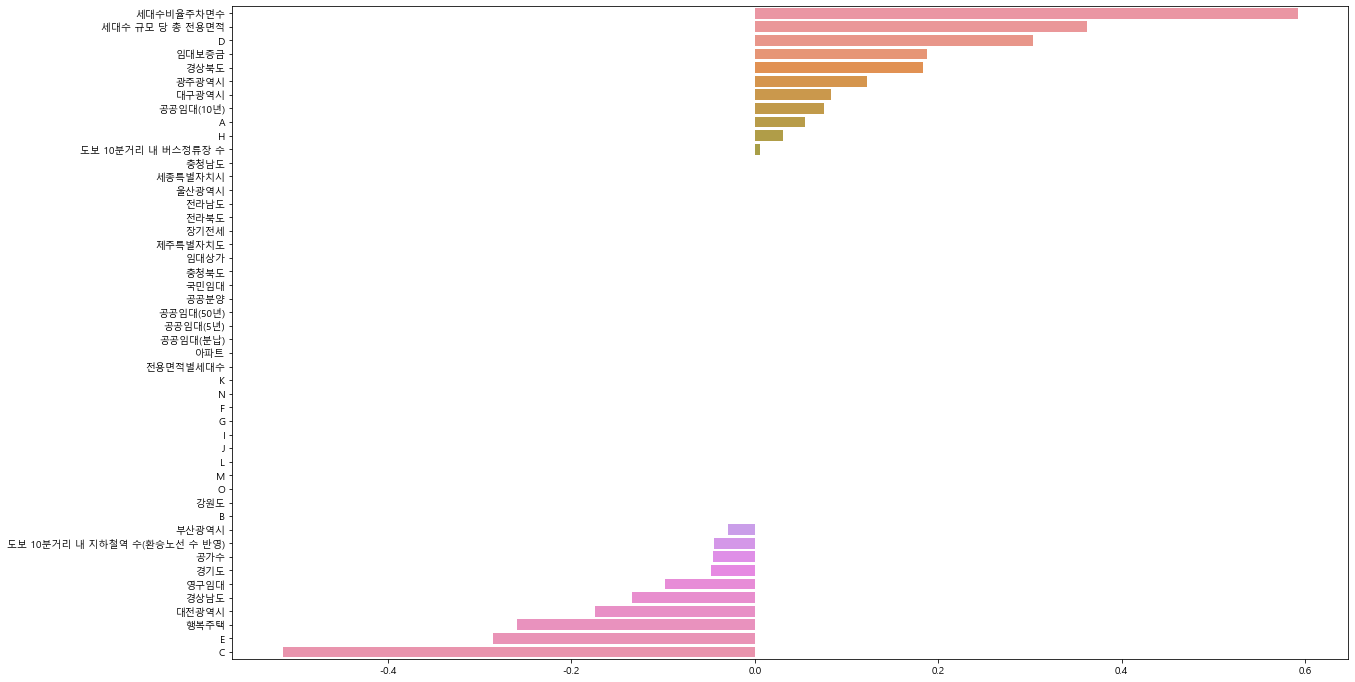

In [100]:
importance = lasso_grid.best_estimator_.coef_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [101]:
lasso_best = lasso_grid.best_estimator_


X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = lasso_best.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.877152764858751

### Ridge & Lasso & CatBoost 조합 -> 0.2 & 0.2 & 0.6 조합

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)

mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

Learning rate set to 0.04469
0:	learn: 1.7651104	total: 1.58ms	remaining: 1.58s
1:	learn: 1.6931987	total: 3ms	remaining: 1.5s
2:	learn: 1.6262732	total: 4.32ms	remaining: 1.44s
3:	learn: 1.5623421	total: 5.64ms	remaining: 1.41s
4:	learn: 1.4990656	total: 6.92ms	remaining: 1.38s
5:	learn: 1.4378812	total: 8.33ms	remaining: 1.38s
6:	learn: 1.3806417	total: 9.73ms	remaining: 1.38s
7:	learn: 1.3250999	total: 11.1ms	remaining: 1.38s
8:	learn: 1.2737974	total: 12.6ms	remaining: 1.39s
9:	learn: 1.2243690	total: 14ms	remaining: 1.38s
10:	learn: 1.1781528	total: 15.2ms	remaining: 1.37s
11:	learn: 1.1351365	total: 16.6ms	remaining: 1.37s
12:	learn: 1.0912127	total: 18ms	remaining: 1.36s
13:	learn: 1.0498541	total: 19.3ms	remaining: 1.36s
14:	learn: 1.0092679	total: 20.7ms	remaining: 1.36s
15:	learn: 0.9704660	total: 22.1ms	remaining: 1.36s
16:	learn: 0.9337089	total: 23.3ms	remaining: 1.35s
17:	learn: 0.8990754	total: 24.6ms	remaining: 1.34s
18:	learn: 0.8664793	total: 25.9ms	remaining: 1.34s
1

260:	learn: 0.1902818	total: 327ms	remaining: 926ms
261:	learn: 0.1900103	total: 328ms	remaining: 924ms
262:	learn: 0.1896583	total: 329ms	remaining: 923ms
263:	learn: 0.1894835	total: 331ms	remaining: 922ms
264:	learn: 0.1893913	total: 332ms	remaining: 921ms
265:	learn: 0.1893216	total: 333ms	remaining: 919ms
266:	learn: 0.1889560	total: 334ms	remaining: 918ms
267:	learn: 0.1885500	total: 336ms	remaining: 916ms
268:	learn: 0.1883084	total: 337ms	remaining: 915ms
269:	learn: 0.1880575	total: 338ms	remaining: 914ms
270:	learn: 0.1877316	total: 339ms	remaining: 912ms
271:	learn: 0.1876724	total: 340ms	remaining: 911ms
272:	learn: 0.1871145	total: 342ms	remaining: 910ms
273:	learn: 0.1868262	total: 343ms	remaining: 909ms
274:	learn: 0.1867517	total: 344ms	remaining: 907ms
275:	learn: 0.1866158	total: 345ms	remaining: 906ms
276:	learn: 0.1865437	total: 346ms	remaining: 904ms
277:	learn: 0.1861780	total: 348ms	remaining: 903ms
278:	learn: 0.1861076	total: 349ms	remaining: 901ms
279:	learn: 

544:	learn: 0.1396204	total: 666ms	remaining: 556ms
545:	learn: 0.1394176	total: 668ms	remaining: 555ms
546:	learn: 0.1392309	total: 669ms	remaining: 554ms
547:	learn: 0.1391197	total: 670ms	remaining: 553ms
548:	learn: 0.1391061	total: 671ms	remaining: 551ms
549:	learn: 0.1389591	total: 673ms	remaining: 550ms
550:	learn: 0.1389509	total: 674ms	remaining: 549ms
551:	learn: 0.1388750	total: 675ms	remaining: 548ms
552:	learn: 0.1387554	total: 676ms	remaining: 547ms
553:	learn: 0.1386256	total: 677ms	remaining: 545ms
554:	learn: 0.1384588	total: 679ms	remaining: 544ms
555:	learn: 0.1382858	total: 680ms	remaining: 543ms
556:	learn: 0.1381967	total: 681ms	remaining: 542ms
557:	learn: 0.1380390	total: 682ms	remaining: 541ms
558:	learn: 0.1378003	total: 684ms	remaining: 539ms
559:	learn: 0.1376313	total: 685ms	remaining: 538ms
560:	learn: 0.1375286	total: 686ms	remaining: 537ms
561:	learn: 0.1372758	total: 687ms	remaining: 536ms
562:	learn: 0.1371173	total: 689ms	remaining: 534ms
563:	learn: 

824:	learn: 0.1093531	total: 1s	remaining: 213ms
825:	learn: 0.1092786	total: 1s	remaining: 212ms
826:	learn: 0.1092117	total: 1.01s	remaining: 211ms
827:	learn: 0.1091681	total: 1.01s	remaining: 209ms
828:	learn: 0.1090898	total: 1.01s	remaining: 208ms
829:	learn: 0.1090447	total: 1.01s	remaining: 207ms
830:	learn: 0.1089437	total: 1.01s	remaining: 206ms
831:	learn: 0.1089042	total: 1.01s	remaining: 204ms
832:	learn: 0.1088706	total: 1.01s	remaining: 203ms
833:	learn: 0.1087866	total: 1.01s	remaining: 202ms
834:	learn: 0.1087162	total: 1.02s	remaining: 201ms
835:	learn: 0.1086813	total: 1.02s	remaining: 200ms
836:	learn: 0.1086179	total: 1.02s	remaining: 198ms
837:	learn: 0.1085003	total: 1.02s	remaining: 197ms
838:	learn: 0.1084516	total: 1.02s	remaining: 196ms
839:	learn: 0.1083810	total: 1.02s	remaining: 195ms
840:	learn: 0.1083367	total: 1.02s	remaining: 194ms
841:	learn: 0.1082353	total: 1.02s	remaining: 192ms
842:	learn: 0.1081979	total: 1.03s	remaining: 191ms
843:	learn: 0.1081

10.896392621172573

In [113]:
ridge_model = Ridge(alpha=40)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_df_log, y_train_df_log)
lasso_pred = lasso_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub = sub.rename(columns={"code":"단지코드"})
sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge(0.2) & lasso(0.2)& catboost(0.6)조합_공급유형추가_임대보증금지역평균처리_0727.csv", index=False)

sub_df

Learning rate set to 0.04704
0:	learn: 1.7676229	total: 1.64ms	remaining: 1.64s
1:	learn: 1.6932546	total: 3.17ms	remaining: 1.58s
2:	learn: 1.6217231	total: 4.67ms	remaining: 1.55s
3:	learn: 1.5526314	total: 6.1ms	remaining: 1.52s
4:	learn: 1.4867309	total: 7.54ms	remaining: 1.5s
5:	learn: 1.4234335	total: 9ms	remaining: 1.49s
6:	learn: 1.3636359	total: 10.6ms	remaining: 1.51s
7:	learn: 1.3090268	total: 11.6ms	remaining: 1.44s
8:	learn: 1.2553209	total: 13.1ms	remaining: 1.44s
9:	learn: 1.2058376	total: 14.5ms	remaining: 1.43s
10:	learn: 1.1571041	total: 16ms	remaining: 1.44s
11:	learn: 1.1100577	total: 17.3ms	remaining: 1.43s
12:	learn: 1.0682096	total: 18.5ms	remaining: 1.41s
13:	learn: 1.0259407	total: 20ms	remaining: 1.41s
14:	learn: 0.9853738	total: 21.5ms	remaining: 1.41s
15:	learn: 0.9464661	total: 23ms	remaining: 1.41s
16:	learn: 0.9106405	total: 24.3ms	remaining: 1.41s
17:	learn: 0.8768538	total: 25.8ms	remaining: 1.41s
18:	learn: 0.8424790	total: 27.2ms	remaining: 1.4s
19:	l

236:	learn: 0.2017931	total: 334ms	remaining: 1.08s
237:	learn: 0.2017085	total: 337ms	remaining: 1.08s
238:	learn: 0.2014751	total: 339ms	remaining: 1.08s
239:	learn: 0.2013001	total: 341ms	remaining: 1.08s
240:	learn: 0.2009592	total: 344ms	remaining: 1.08s
241:	learn: 0.2005747	total: 346ms	remaining: 1.08s
242:	learn: 0.2004710	total: 348ms	remaining: 1.08s
243:	learn: 0.2003564	total: 349ms	remaining: 1.08s
244:	learn: 0.2001513	total: 351ms	remaining: 1.08s
245:	learn: 0.1999714	total: 353ms	remaining: 1.08s
246:	learn: 0.1999210	total: 354ms	remaining: 1.08s
247:	learn: 0.1995516	total: 356ms	remaining: 1.08s
248:	learn: 0.1992028	total: 357ms	remaining: 1.08s
249:	learn: 0.1988463	total: 359ms	remaining: 1.08s
250:	learn: 0.1984012	total: 360ms	remaining: 1.07s
251:	learn: 0.1983526	total: 362ms	remaining: 1.07s
252:	learn: 0.1980945	total: 363ms	remaining: 1.07s
253:	learn: 0.1976182	total: 364ms	remaining: 1.07s
254:	learn: 0.1972850	total: 366ms	remaining: 1.07s
255:	learn: 

493:	learn: 0.1491516	total: 672ms	remaining: 688ms
494:	learn: 0.1490442	total: 673ms	remaining: 687ms
495:	learn: 0.1487941	total: 675ms	remaining: 685ms
496:	learn: 0.1485906	total: 676ms	remaining: 684ms
497:	learn: 0.1484316	total: 677ms	remaining: 683ms
498:	learn: 0.1482369	total: 678ms	remaining: 681ms
499:	learn: 0.1481376	total: 680ms	remaining: 680ms
500:	learn: 0.1480367	total: 681ms	remaining: 678ms
501:	learn: 0.1479129	total: 683ms	remaining: 677ms
502:	learn: 0.1477497	total: 684ms	remaining: 676ms
503:	learn: 0.1475384	total: 685ms	remaining: 674ms
504:	learn: 0.1473551	total: 687ms	remaining: 673ms
505:	learn: 0.1471640	total: 688ms	remaining: 672ms
506:	learn: 0.1469193	total: 689ms	remaining: 670ms
507:	learn: 0.1468129	total: 691ms	remaining: 669ms
508:	learn: 0.1466878	total: 692ms	remaining: 668ms
509:	learn: 0.1465602	total: 694ms	remaining: 667ms
510:	learn: 0.1463841	total: 695ms	remaining: 665ms
511:	learn: 0.1462464	total: 696ms	remaining: 664ms
512:	learn: 

755:	learn: 0.1191595	total: 1.01s	remaining: 326ms
756:	learn: 0.1190465	total: 1.01s	remaining: 325ms
757:	learn: 0.1188683	total: 1.01s	remaining: 324ms
758:	learn: 0.1187793	total: 1.01s	remaining: 322ms
759:	learn: 0.1187127	total: 1.02s	remaining: 321ms
760:	learn: 0.1186361	total: 1.02s	remaining: 320ms
761:	learn: 0.1185861	total: 1.02s	remaining: 318ms
762:	learn: 0.1185478	total: 1.02s	remaining: 317ms
763:	learn: 0.1184910	total: 1.02s	remaining: 316ms
764:	learn: 0.1184151	total: 1.02s	remaining: 314ms
765:	learn: 0.1182745	total: 1.02s	remaining: 313ms
766:	learn: 0.1182481	total: 1.03s	remaining: 312ms
767:	learn: 0.1180706	total: 1.03s	remaining: 310ms
768:	learn: 0.1180202	total: 1.03s	remaining: 309ms
769:	learn: 0.1179284	total: 1.03s	remaining: 308ms
770:	learn: 0.1178963	total: 1.03s	remaining: 306ms
771:	learn: 0.1177385	total: 1.03s	remaining: 305ms
772:	learn: 0.1176668	total: 1.03s	remaining: 304ms
773:	learn: 0.1175573	total: 1.03s	remaining: 302ms
774:	learn: 

,code,num
0,C1072,718.806658
1,C1128,1327.942359
2,C1456,493.850696
3,C1840,468.705592
4,C1332,1177.584001
...,...,...
145,C2456,237.762458
146,C1266,416.566304
147,C2152,26.313905
148,C1267,325.652311
